In [3]:
import os, random, time
import cv2, imutils
from skimage.measure import compare_ssim
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
%cd '/Users/sharan_srinivasan/Documents/adhoc/kilaigal'

/Users/sharan_srinivasan/Documents/adhoc/kilaigal


1. Read a sample video stream
2. Fetch base frame,
3. Diff generator --> Identify motion changes, record ts and callback to chunk display
4. Process frames : BW,Guassian ablation, thresholding, countour detection --> Object localization. Callback to localized object image saver
5. end stream and output ts chunks. 
6. Try to output one frame of the localized object

In [5]:
# Read the file and get an initial frame
vid = cv2.VideoCapture('videos/Water Drop-Small.mp4')
frame_idx = 0

In [6]:
ret, baseFrame = vid.read()
def get_next_frame():    
    global frame_idx
    i = frame_idx
    while i < frame_idx + 80:
        ret, nextFrame = vid.read()
        i+=1
        if ret == False:
            break;
    frame_idx = i
    print(frame_idx)
    return nextFrame

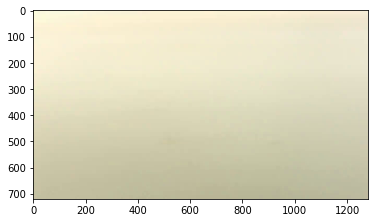

In [7]:
plt.imshow(baseFrame)
plt.show()

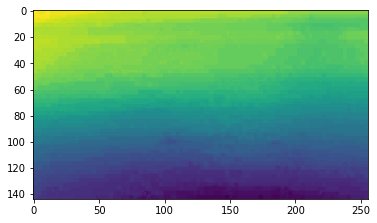

In [9]:
# cv2.imshow('frame',preProcessImageFrame(frame))
basePFrame = preProcessImageFrame(baseFrame)
plt.imshow(basePFrame)
plt.show()

80


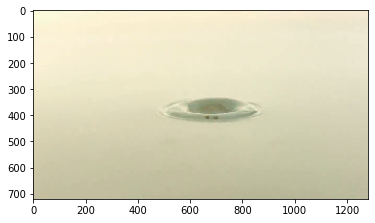

In [10]:
#Read a new frame fromt the video, process and diff it with the base
nextFrame = get_next_frame()
plt.imshow(nextFrame)
plt.show()

In [11]:
nextPFrame = preProcessImageFrame(nextFrame)

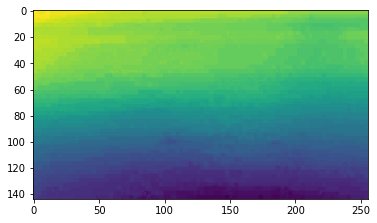

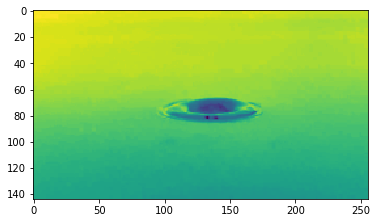

In [12]:
plt.imshow(basePFrame)
plt.show()
plt.imshow(nextPFrame)
plt.show()

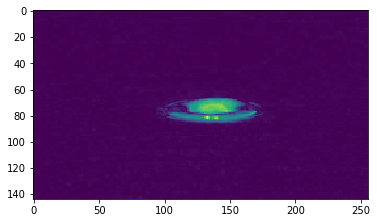

In [13]:
# get the diff
frameDelta = cv2.absdiff(basePFrame, nextPFrame)
plt.imshow(frameDelta)

plt.show()

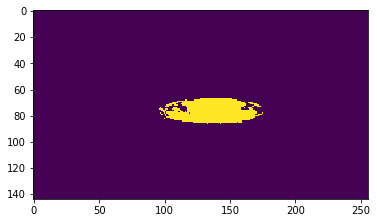

In [14]:
# Threshold the image so as to help with localization
frameDeltaThresholded = cv2.threshold(frameDelta, 8, 255, cv2.THRESH_BINARY)
imageDiff = frameDeltaThresholded[1]
plt.imshow(imageDiff)
plt.show()

In [15]:
# check the framedelta's rmse 
def compute_rmse_from_image_diff(imageDiff):
    diffSum = np.sum(imageDiff.astype('float')**2)
    diffCardinality = (imageDiff.shape[0]*imageDiff.shape[1])
    rmse = np.sqrt(diffSum/ diffCardinality)
    return rmse

compute_rmse_from_image_diff(frameDeltaThresholded[1])

def compute_structural_similarity(imgage, reference):
    s = compare_ssim(imgage, reference)
    return s
compute_structural_similarity(nextPFrame, basePFrame)

0.952255214091068

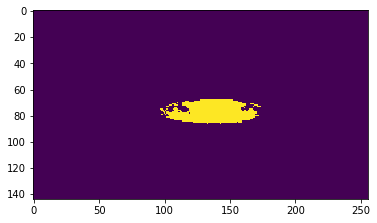

In [16]:
# generate contours from the imageDiff, but dialate first
dialatedImageDiff = cv2.blur(imageDiff, (2,2))
contours, hierarchy = cv2.findContours(dialatedImageDiff, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
# plot the contours 
RED = (0, 255, 0)
plt.imshow(cv2.drawContours(imageDiff, contours, -1, RED, 0))


In [19]:
# loop over the contours
for c in contours:
    # if the contour is too small, ignore it
    print(cv2.contourArea(c))
    if cv2.contourArea(c) < 100:
        continue

    # compute the bounding box for the contour, draw it on the frame,
    # and update the text
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(basePFrame, (x, y), (x + w, y + h), (0, 255, 0), 2)
    text = "Occupied"

1183.0
2.0
4.0
10.0
2.0
8.5
28.0


In [20]:
cv2.imshow('s', basePFrame)

In [12]:
def playMe():
    cap = cv2.VideoCapture('videos/Water Drop-Small.mp4')

    while(cap.isOpened()):
        ret, frame = cap.read()

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #     gray = frame

        cv2.imshow('frame',gray)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            cap.release()
            cv2.destroyAllWindows()
            break

    cap.release()
    cv2.destroyAllWindows()

In [21]:
def preProcessImageFrame(frame):
    # Resize the image so it plays nicely with openCV
    frame = imutils.resize(frame, width=256, height=256)
    # Convert it to grayscale to enable simple diffing
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Add some blur to smooth and get rid of noise
    frame = cv2.blur(frame, (1, 1), 0)
    return frame

In [29]:

motion_frame_nums = []
cap = cv2.VideoCapture('videos/Water Drop-Small.mp4')
baseFrame = None
SIMILARITY_THRESHOLD = 0.95
frame_num = 0 # codex frame index
motion_state = 0 # Whether the video is in motion
    
while(cap.isOpened()):
    # Get the current frame and preprocess it
    ret, frame = cap.read()
    if(ret == False):
        print("Video stream not recieved. Aborting ...")
        break;
        
    ppFrame = preProcessImageFrame(frame)

    if baseFrame is None:
        baseFrame = ppFrame.copy()
        continue
        
    # Determine if there is a motion sequence and update state
    ssim = compute_structural_similarity(basePFrame, nextPFrame)
    if(ssim < SIMILARITY_THRESHOLD):
        motion_frame_nums.append(frame_num)
        if(motion_state == 0):
            print("Motion sequence detected on frame {}", motion_frame_nums)
            motion_state = 1
    else:
        # When there is no motion, reset the state and end the motion seqeuence
        motion_state = 0
        print("Motion State ended on frame {}", frame_idx)
    
    
    frame_num +=1
    
    ## To localize the Image
    
    # Get a simple diff with the base frame
    frameDelta = cv2.absdiff(basePFrame, nextPFrame)
    # threshold the delta
    frameDeltaThresholded = cv2.threshold(frameDelta, 8, 255, cv2.THRESH_BINARY)
    
    # play the image
    cv2.imshow('frame',ppFrame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

cap.release()
cv2.destroyAllWindows()

Motion sequence detected on frame {} [0]


KeyboardInterrupt: 